# PI-Deeponet

$$\frac{\partial s}{\partial t} = D_{coeff}\frac{\partial^2 s}{\partial x^2} + K_{coeff}s^2 + u(x)$$\
$$**s(x,0) = 0**$$
boundary condition : periodic\
domain : x = [0,1] and  t = [0,1]

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, concatenate, Lambda
from tensorflow.keras.utils import to_categorical
import scipy.io
import time as time_lib
import scipy.optimize
from scipy.fft import fft, ifft
from scipy.integrate import odeint

In [2]:
n_functions=20 #no of functions
n_sensors=100 #no of sensor points

lb_A=-1 #lowerbound of coefficient
ub_A=1 #upperbound of coefficient
L=1
nx = 30 # no of grid points for x
nt = 30 # no of grid points for t

n_bdr=200
n_train=nx*nt

# domain
x_0=0
x_l=1
t_0=0
t_l=1

#for trunck-inside points
x=np.linspace(x_0,x_l,nx)
t=np.linspace(t_0,t_l,nt)

#boundary points
x_bdr=np.random.rand(n_bdr)
t_bdr=np.zeros(n_bdr)

#for trunck
x_sensor=np.linspace(0,1,n_sensors)

t=np.reshape(t,(len(t),1))
x=np.reshape(x,(len(x),1))

x_eval,t_eval = np.meshgrid(x,t)

x_eval=np.reshape(x_eval,-1)
t_eval=np.reshape(t_eval,-1)
x_bdr=np.reshape(x_bdr,-1)
t_bdr=np.reshape(t_bdr,-1)

y=np.concatenate([x_eval[:, None], t_eval[:, None]],axis=1)
y_bdr=np.concatenate([x_bdr[:, None], t_bdr[:, None]],axis=1)

A=np.random.rand(n_functions)
B=np.random.rand(n_functions)

D_coeff  = 0.01 # constant in PDE
K_coeff = 0.01 # constant in PDE

#functions
def fn(A,B,x):
    return np.cos(2*np.pi*A*x)+np.sin(2*np.pi*B*x)

#DNS
def sol_reaction_diff(u,t,K_coeff,D_coeff):

    s_0 = u*0.0

    def rhsf(s, t):
        N = len(s)
        n = np.arange(N); n[int(N/2)+1:]-= N
        return K_coeff*s**2 - D_coeff*ifft((2*np.pi*n/L)**2*fft(s)).real + u

    sol = odeint(rhsf, s_0, t)

    return sol

f=[]
for i in range(n_functions):
    f.append(fn(A[i],B[i],x_sensor))

f=np.array(f)

In [3]:
f.shape

(20, 100)

In [4]:
#create X_train

#x_branch and x_branch to train
X_train_branch=[]
X_train_trunck=[]
A_train=[]
B_train=[]

for i in range(n_functions):
    for j in range(n_train):
        X_train_branch.append(f[i])
        X_train_trunck.append(y[j])

        A_train.append(A[i])
        B_train.append(B[i])

X_train_branch=np.array(X_train_branch)
X_train_trunck=np.array(X_train_trunck)

A_train=np.array(A_train)
B_train=np.array(B_train)

#create X_train for boundary

#x_branch and x_branch to train
X_train_branch_bdr=[]
X_train_trunck_bdr=[]
A_train_bdr=[]
B_train_bdr=[]

for i in range(n_functions):
    for j in range(n_bdr):
        X_train_branch_bdr.append(f[i])
        X_train_trunck_bdr.append(y_bdr[j])

        A_train_bdr.append(A[i])
        B_train_bdr.append(B[i])

X_train_branch_bdr=np.array(X_train_branch_bdr)
X_train_trunck_bdr=np.array(X_train_trunck_bdr)

A_train_bdr=np.array(A_train_bdr)
B_train_bdr=np.array(B_train_bdr)

In [5]:
X_train_br=tf.convert_to_tensor(X_train_branch, dtype=tf.float32, dtype_hint=None, name=None)
X_train_tr=tf.convert_to_tensor(X_train_trunck, dtype=tf.float32, dtype_hint=None, name=None)
A_train=tf.convert_to_tensor(A_train, dtype=tf.float32, dtype_hint=None, name=None)
B_train=tf.convert_to_tensor(B_train, dtype=tf.float32, dtype_hint=None, name=None)

X_train_br_bdr=tf.convert_to_tensor(X_train_branch_bdr, dtype=tf.float32, dtype_hint=None, name=None)
X_train_tr_bdr=tf.convert_to_tensor(X_train_trunck_bdr, dtype=tf.float32, dtype_hint=None, name=None)
A_train_bdr=tf.convert_to_tensor(A_train_bdr, dtype=tf.float32, dtype_hint=None, name=None)
B_train_bdr=tf.convert_to_tensor(B_train_bdr, dtype=tf.float32, dtype_hint=None, name=None)

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((X_train_br, X_train_tr, A_train,B_train))
dataset_bdr=tf.data.Dataset.from_tensor_slices((X_train_br_bdr, X_train_tr_bdr, A_train_bdr,B_train_bdr))

batch_size = 10000  # Adjust this based on needs
batch_size_bdr = 5000

dataset = dataset.batch(batch_size)
dataset_bdr = dataset_bdr.batch(batch_size_bdr)

In [10]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam()
tf.keras.backend.set_floatx('float32')

#model for deepOnet###########################################################

#no of sensor points
m=n_sensors
branch_input = Input(shape=(m,), name='vector_input')
trunck_input = Input(shape=(2,), name='scalar_input')

#branch network
branch_net = Dense(128, activation='tanh')(branch_input)
branch_net = Dense(128, activation='tanh')(branch_net)
branch_net = Dense(128, activation='tanh')(branch_net)
branch_net = Dense(128, activation='tanh')(branch_net)
branch_net = Dense(128, activation='tanh')(branch_net)
branch_net = Dense(128, activation='tanh')(branch_net)
branch_net = Dense(m, activation='tanh')(branch_net)

# Trunck network
trunck_net = Dense(128, activation='tanh')(trunck_input)
trunck_net = Dense(128, activation='tanh')(trunck_net)
trunck_net = Dense(128, activation='tanh')(trunck_net)
trunck_net = Dense(128, activation='tanh')(trunck_net)
trunck_net = Dense(128, activation='tanh')(trunck_net)
trunck_net = Dense(128, activation='tanh')(trunck_net)
trunck_net = Dense(m, activation='tanh')(trunck_net)
#bias = tf.Variable(0., shape=(), trainable=True)

dot_product = Lambda(lambda x: tf.reduce_sum(x[0] * x[1], axis=1, keepdims=True))([branch_net, trunck_net])
model = tf.keras.Model(inputs=[branch_input, trunck_input], outputs=dot_product)

###############################################################################

def loss(X_br,X_tr,A,B):
    with tf.GradientTape(persistent=True) as tape:

            x,t=tf.unstack(X_tr,axis=1)
            tape.watch(x)
            tape.watch(t)

            s = model([X_br, tf.stack((x,t),axis=1)], training=True)
            dsdx=tape.gradient(s,x)
            d2sdx2=tape.gradient(dsdx,x)

            dsdt=tape.gradient(s,t)
            u=fn(A,B,x)

            loss = tf.reduce_mean(tf.square(dsdt-D_coeff*d2sdx2-K_coeff*tf.square(s)-u))

    return loss

def loss_bdr(X_br,X_tr,A,B):
    with tf.GradientTape(persistent=True) as tape:

            x,t=tf.unstack(X_tr,axis=1)
            tape.watch(x)
            tape.watch(t)

            s = model([X_br, tf.stack((x,t),axis=1)], training=True)
            dsdx=tape.gradient(s,x)
            d2sdx2=tape.gradient(dsdx,x)

            dsdt=tape.gradient(s,t)
            u=fn(A,B,x)

            loss2=tf.reduce_mean(tf.square(s))#initial loss

            loss = tf.reduce_mean(tf.square(dsdt-D_coeff*d2sdx2-K_coeff*tf.square(s)-u))#equation loss

    return loss+loss2

In [12]:
# Training loop

# Define a learning rate schedule
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100, decay_rate=0.9)

# Define the optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

for epoch in range(500):
    for X_br, X_tr, A,B in dataset:
        with tf.GradientTape() as tape:

            loss_value = loss(X_br,X_tr,A,B)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    for X_br, X_tr, A,B in dataset_bdr:
        with tf.GradientTape() as tape:

            loss_value = loss_bdr(X_br,X_tr,A,B)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % 5 == 0:
        print(f"Epoch {epoch}, loss={loss_value:.6f}")

Epoch 0, loss=1.273517
Epoch 5, loss=1.104320
Epoch 10, loss=0.939943
Epoch 15, loss=0.568580
Epoch 20, loss=0.416016
Epoch 25, loss=0.325767
Epoch 30, loss=0.288071
Epoch 35, loss=0.239412
Epoch 40, loss=0.217511
Epoch 45, loss=0.138091
Epoch 50, loss=0.094270
Epoch 55, loss=0.077419
Epoch 60, loss=0.110467
Epoch 65, loss=0.093810
Epoch 70, loss=0.043879
Epoch 75, loss=0.038105
Epoch 80, loss=0.039514
Epoch 85, loss=0.035082
Epoch 90, loss=0.030879
Epoch 95, loss=0.122076
Epoch 100, loss=0.028779
Epoch 105, loss=0.023622
Epoch 110, loss=0.028360
Epoch 115, loss=0.023539
Epoch 120, loss=0.017487
Epoch 125, loss=0.016647
Epoch 130, loss=0.015743
Epoch 135, loss=0.015225
Epoch 140, loss=0.014885
Epoch 145, loss=0.013461
Epoch 150, loss=0.018272
Epoch 155, loss=0.040664
Epoch 160, loss=0.013737
Epoch 165, loss=0.012938
Epoch 170, loss=0.010431
Epoch 175, loss=0.009999
Epoch 180, loss=0.009693
Epoch 185, loss=0.009419
Epoch 190, loss=0.010187
Epoch 195, loss=0.011712
Epoch 200, loss=0.0172

In [13]:
#prediction for a-new function, test data prep
A_new=np.random.rand()
B_new=np.random.rand()
X_test_branch=[]
X_test_trunck=[]

f_new=fn(A_new,B_new,x_sensor)
for i in range(1):
    for j in range(n_train):
        X_test_branch.append(f_new)
        X_test_trunck.append(y[j])


X_test_branch=np.array(X_test_branch)
X_test_trunck=np.array(X_test_trunck)

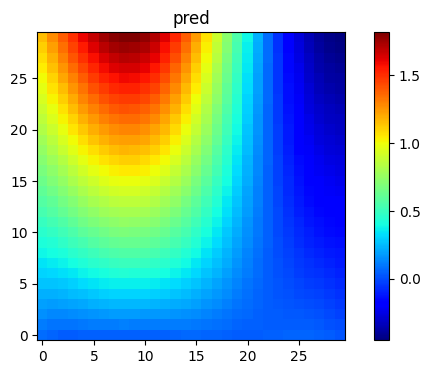

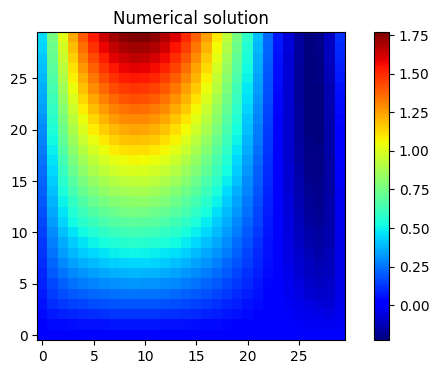

In [16]:
#new unseen function pred
s=model([X_test_branch, X_test_trunck])
tt=tf.reshape(s,(nx,nt))

x=np.linspace(0,1,nx)
t=np.linspace(0,1,nt)
t=np.reshape(t,(len(t),1))
x=np.reshape(x,(len(x),1))
x_eval,t_eval = np.meshgrid(x,t)

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121)
ax1.set_title('pred')
im1 = ax1.imshow(tt,cmap='jet',origin='lower')
fig.colorbar(im1, orientation='vertical')

#numerical sol for the test function
x=np.linspace(0,1,nx)
t=np.linspace(0,1,nt)
u_inp_fun=fn(A_new,B_new,x)
sol_fun =  sol_reaction_diff(u_inp_fun,t,K_coeff,D_coeff)

#plot the results
fig = plt.figure(figsize=(16,4))
ax2 = fig.add_subplot(121)
ax2.set_title('Numerical solution')
im2 = ax2.imshow(sol_fun,cmap='jet',origin='lower')
fig.colorbar(im2, orientation='vertical')
plt.show()

In [17]:
'''
#new unseen function pred
#s=model([X_test_branch, X_test_trunck])
s=model([X_train_branch[nx*nt:], X_train_trunck[nt*nx:]])
tt=tf.reshape(s,(nx,nt))

x=np.linspace(0,1,nx)
t=np.linspace(0,1,nt)
t=np.reshape(t,(len(t),1))
x=np.reshape(x,(len(x),1))
x_eval,t_eval = np.meshgrid(x,t)

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121)
ax1.set_title('pred')
im1 = ax1.imshow(tt,cmap='jet',origin='lower')
fig.colorbar(im1, orientation='vertical')

#numerical sol for the test function
x=np.linspace(0,1,nx)
t=np.linspace(0,1,nt)
u_inp_fun=fn(A[1],B[1],x)
sol_fun =  sol_reaction_diff(u_inp_fun,t,K_coeff,D_coeff)

#plot the results
fig = plt.figure(figsize=(16,4))
ax2 = fig.add_subplot(121)
ax2.set_title('true')
im2 = ax2.imshow(sol_fun,cmap='jet',origin='lower')
fig.colorbar(im2, orientation='vertical')
plt.show()
'''

"\n#new unseen function pred\n#s=model([X_test_branch, X_test_trunck])\ns=model([X_train_branch[nx*nt:], X_train_trunck[nt*nx:]])\ntt=tf.reshape(s,(nx,nt))\n\nx=np.linspace(0,1,nx)\nt=np.linspace(0,1,nt)\nt=np.reshape(t,(len(t),1))\nx=np.reshape(x,(len(x),1))\nx_eval,t_eval = np.meshgrid(x,t)\n\nfig = plt.figure(figsize=(16,4))\nax1 = fig.add_subplot(121)\nax1.set_title('pred')\nim1 = ax1.imshow(tt,cmap='jet',origin='lower')\nfig.colorbar(im1, orientation='vertical')\n\n#numerical sol for the test function\nx=np.linspace(0,1,nx)\nt=np.linspace(0,1,nt)\nu_inp_fun=fn(A[1],B[1],x)\nsol_fun =  sol_reaction_diff(u_inp_fun,t,K_coeff,D_coeff)\n\n#plot the results\nfig = plt.figure(figsize=(16,4))\nax2 = fig.add_subplot(121)\nax2.set_title('true')\nim2 = ax2.imshow(sol_fun,cmap='jet',origin='lower')\nfig.colorbar(im2, orientation='vertical')\nplt.show()\n"